# Reading data ana prepare pyspark

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1FU6NJFNr4x_7Sohk-kAFGb3uvlemOdsY'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Death_Dataset.zip')

In [ ]:
!mkdir /content/Death_Dataset
!unzip -q /content/Death_Dataset.zip -d /content/Death_Dataset

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 198 kB 57.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=1af5324465808c56588526bd259fed0592b0eef69d31398199262727e775debc
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import json
import numpy as np

In [ ]:
spark = SparkSession.builder.appName("death").getOrCreate()
df = spark.read.csv("/content/Death_Dataset/2005_data.csv")

# SHOW function 


In [ ]:
import matplotlib.pyplot as plt
def show(name,val,x_name,y_name,tit):
    fig = plt.figure(figsize = (10, 5))
    
    # creating the bar plot
    plt.bar(name, val, color ='maroon',
            width = 0.4)
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(tit)
    plt.show()

# Using Header Record For Column Names

In [ ]:
death_2005_data = spark.read.option("header",True).csv("/content/Death_Dataset/2005_data.csv")

# Read json

In [ ]:
def read_json(path):
  with open(path, 'r') as f:
        code=json.load(f)
        return code

### 2005 data

In [ ]:
death_2005_data.show()

+---------------+-----------------------+-----------------------+------------------------+--------------+---+---------------+----------+---------------------+-------------+-------------+-------------+--------------------+-----------------------------------+--------------+--------------------+-----------------+--------------+---------------+---------------------+-------+-------------+------------------------------------------------------+----------------------+----------------+----------------+-----------------------+---------------+--------------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------------------+-----

In [ ]:
wordCounts_manner = (death_2005_data.groupBy('manner_of_death').count())
wordCounts_manner.show()

+---------------+-------+
|manner_of_death|  count|
+---------------+-------+
|              7|1537327|
|              3|  19235|
|              5|   9131|
|              1| 113949|
|              4|   7039|
|              2|  32934|
|           null| 732891|
+---------------+-------+



In [ ]:
from pyspark.sql.functions import col

def Get_wordcount_specific_column (path,column_name):
  read_data = spark.read.option("header",True).csv(path)
  specific_column = read_data.select(col(column_name))
  wordcount_column = (specific_column.groupBy(column_name).count())

  return wordcount_column

# 2005 Day_death

In [ ]:
data_2005_day_death = Get_wordcount_specific_column ("/content/Death_Dataset/2005_data.csv","day_of_week_of_death")
data_2005_day_death.show()

+--------------------+------+
|day_of_week_of_death| count|
+--------------------+------+
|                   7|362584|
|                   3|346973|
|                   5|347244|
|                   6|350725|
|                   1|347512|
|                   4|346635|
|                   2|350823|
|                   9|    10|
+--------------------+------+



In [ ]:
def df_to_arr(df,column_name):
  count=df.toPandas()['count'].values
  arr=df.toPandas()[column_name].values
  return count,arr
  
count,days=df_to_arr(data_2005_day_death,'day_of_week_of_death') 
code_2005=read_json('/content/Death_Dataset/2005_codes.json')

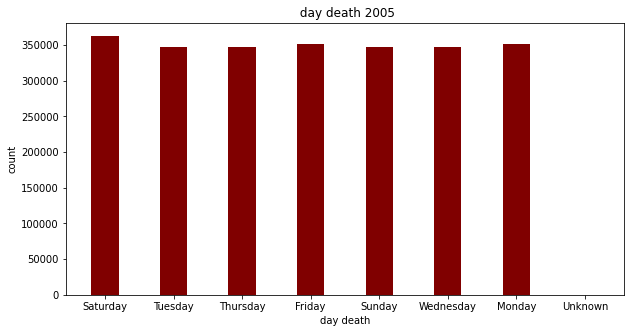

In [ ]:
show([*map(code_2005['day_of_week_of_death'].get, list(days))],count,'day death','count',' day death 2005')

# 2010 day_death

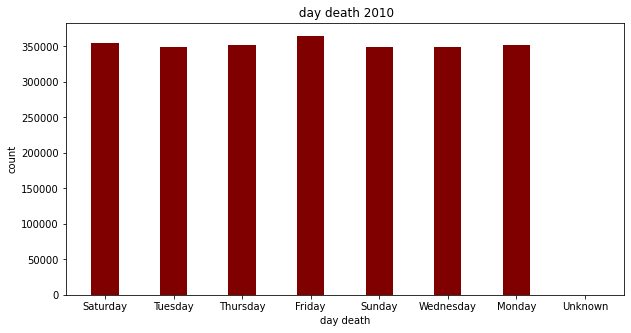

In [ ]:
data_2010_day_death = Get_wordcount_specific_column ("/content/Death_Dataset/2010_data.csv","day_of_week_of_death")
count,days=df_to_arr(data_2010_day_death,'day_of_week_of_death') 
code_2010=read_json('/content/Death_Dataset/2010_codes.json')
show([*map(code_2010['day_of_week_of_death'].get, list(days))],count,'day death','count',' day death 2010')

In [ ]:
data_2010_day_death = Get_wordcount_specific_column ("/content/Death_Dataset/2010_data.csv","race")
count,days=df_to_arr(data_2010_day_death,'race') 
code_2010=read_json('/content/Death_Dataset/2010_codes.json')



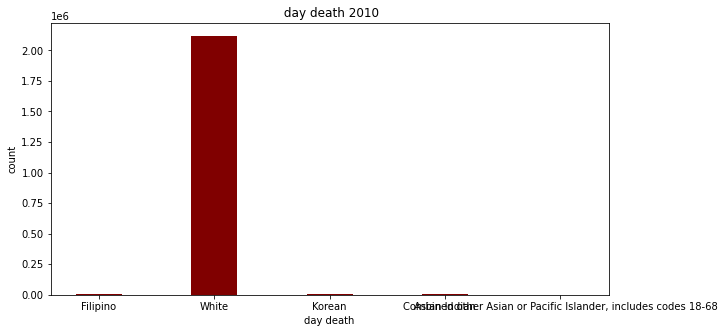

In [ ]:
show([*map(code_2010['race'].get, list(days[0:5]))],count[0:5],'day death','count',' day death 2010')

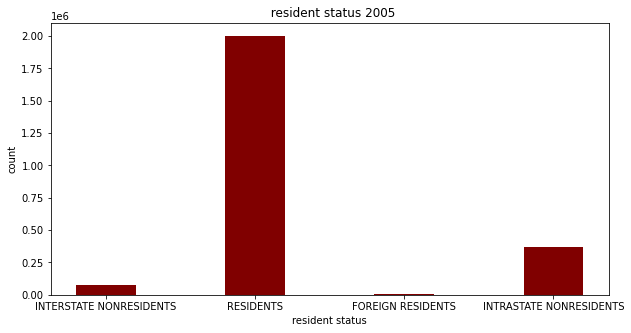

In [ ]:
data_2005_resident_status = Get_wordcount_specific_column ("/content/Death_Dataset/2005_data.csv","resident_status")
count,resident=df_to_arr(data_2005_resident_status,'resident_status') 

show([*map(code_2005['resident_status'].get, list(resident))],count,'resident status','count','  resident status 2005')

### converting into csv

In [ ]:
import csv
def convert_to_csv (json_file,name_of_column,count_of_this_column,data_before_mapping,outputted_csv):
  Mapped_array = []
  for i in data_before_mapping:
    for key in json_file[name_of_column]:
      if key == i:
        Mapped_array.append(json_file[name_of_column][key])

  header = [name_of_column,'count']
  with open(outputted_csv, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(len(Mapped_array)):
      row = [Mapped_array[i],count_of_this_column[i]]
      writer.writerow(row)
      row =[]
    f.close()

In [ ]:
convert_to_csv(code_2005,'day_of_week_of_death',count,days,'test.csv')

# Multi Varible 

In [ ]:
def multi_var(path,var1,var2):
  data=spark.read.option("header",True).csv(path)
  return data.groupBy(var1,var2).count()


# Cause_Sex_2005

In [ ]:
cause_sex_2005=multi_var('/content/Death_Dataset/2005_data.csv','manner_of_death','sex')

In [ ]:
df = cause_sex_2005.replace(to_replace=code_2005['manner_of_death'], subset=['manner_of_death'])
df2 = df.replace(to_replace=code_2005['sex'], subset=['sex'])

In [ ]:
df2.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('content/causes_sex')

# Cause_Sex_2010

In [ ]:
cause_sex_2010=multi_var('/content/Death_Dataset/2010_data.csv','manner_of_death','sex')

In [ ]:
code_2010=read_json('/content/Death_Dataset/2010_codes.json')
df = cause_sex_2010.replace(to_replace=code_2010['manner_of_death'], subset=['manner_of_death'])
df2 = df.replace(to_replace=code_2010['sex'], subset=['sex'])

In [ ]:
df2.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('content/causes_sex_2010')

# Cause_Sex_2015

In [ ]:
cause_sex_2015=multi_var('/content/Death_Dataset/2015_data.csv','manner_of_death','sex')

In [ ]:
code_2015=read_json('/content/Death_Dataset/2015_codes.json')
df = cause_sex_2015.replace(to_replace=code_2015['manner_of_death'], subset=['manner_of_death'])
df2 = df.replace(to_replace=code_2015['sex'], subset=['sex'])

In [ ]:
df2.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('content/causes_sex_2015')

# 3-var

In [ ]:
def multi_var_3(path,var1,var2,var3):
  data=spark.read.option("header",True).csv(path)
  return data.groupBy(var1,var2,var3).count()

In [ ]:
from pyspark.sql import functions as sf
cause_age_sex_2015=multi_var_3('/content/Death_Dataset/2010_data.csv','39_cause_recode','age_recode_52','sex')
cause_age_sex_2015=cause_age_sex_2015.withColumn('joined_column',sf.concat(sf.lit('0'), sf.col('39_cause_recode')))
df = cause_age_sex_2015.replace(to_replace=code_2015['39_cause_recode'], subset=['joined_column'])
df2 = df.replace(to_replace=code_2015['sex'], subset=['sex'])
df3 = df2.replace(to_replace=code_2015['age_recode_52'], subset=['age_recode_52'])
df3.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('content/causes_sex_age_2015')

# 2-var 

In [ ]:
code_2005=read_json('/content/Death_Dataset/2005_codes.json')
edu_mar_2005=multi_var('/content/Death_Dataset/2005_data.csv','education_2003_revision','marital_status')

In [ ]:
df=edu_mar_2005.replace(to_replace=code_2005['education_2003_revision'], subset=['education_2003_revision'])
df2 = df.replace(to_replace=code_2005['marital_status'], subset=['marital_status'])

In [ ]:
df2.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('content/mar_edu_2005')

In [ ]:
code_2010=read_json('/content/Death_Dataset/2010_codes.json')
edu_mar_2010=multi_var('/content/Death_Dataset/2010_data.csv','education_2003_revision','marital_status')
df=edu_mar_2010.replace(to_replace=code_2010['education_2003_revision'], subset=['education_2003_revision'])
df2 = df.replace(to_replace=code_2010['marital_status'], subset=['marital_status'])
df2.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('content/mar_edu_2010')

In [ ]:
code_2015=read_json('/content/Death_Dataset/2015_codes.json')
edu_mar_2015=multi_var('/content/Death_Dataset/2015_data.csv','education_2003_revision','marital_status')
df=edu_mar_2015.replace(to_replace=code_2015['education_2003_revision'], subset=['education_2003_revision'])
df2 = df.replace(to_replace=code_2015['marital_status'], subset=['marital_status'])
df2.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('content/mar_edu_2015')